In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from scipy.stats import binom, nbinom
from functools import partial
np.set_printoptions(suppress=True)
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
import tensorflow as tf

In [3]:
from deep_bayes.models import BayesFlow, InvariantNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# Load Germany Data

In [5]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')


date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,3,15)


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
new_cases_obs = np.diff(cases_obs)

# Prior and Model

In [6]:
def convert_params(mu, phi):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = phi
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p


def stationary_prior(batch_size):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    lambd = np.random.lognormal(mean=np.log(0.4), sigma=0.5, size=batch_size)
    mu = np.random.lognormal(mean=np.log(1/8), sigma=0.2, size=batch_size)
    D = np.random.lognormal(mean=np.log(8), sigma=0.2, size=batch_size)
    I0 = np.random.gamma(shape=2, scale=20, size=batch_size)
    psi = np.random.exponential(5, size=batch_size)
    return np.c_[lambd, mu, D, I0, psi]


def stationary_SIR(params, N, T, eps=1e-5):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters and round I0
    lambd, mu, D, I0, psi = params
    I0 = np.ceil(I0)
    D = int(round(D))
    
    # Initial conditions
    S, I, R = [N-I0], [I0], [0]
    
    # Reported new cases
    C = [I0]
    
    # Simulate T-1 tiemsteps
    for t in range(1, T+D):
        
        # Calculate new cases
        I_new = lambd * (I[-1]*S[-1]/N)
        
        # SIR equations
        S_t = S[-1] - I_new
        I_t = np.clip(I[-1] + I_new - mu*I[-1], 0., N)
        R_t = np.clip(R[-1] + mu*I[-1], 0., N)
        
        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        C.append(I_new)
    
    reparam = convert_params(np.clip(np.array(C[D:]), 0, N) + eps, psi)
    C_obs = nbinom(reparam[0], reparam[1]).rvs()
    return C_obs

# Helper functions

In [7]:
def plot_sbc(theta_samples, theta_test, param_names, bins=25,
            figsize=(24, 12), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size
    N = int(theta_test.shape[0])
    

    f, axarr = plt.subplots(1, 5, figsize=figsize)
    axarr = axarr.flat

    # Convert theta test to numpy
    theta_test = theta_test.numpy()

    # Compute ranks (using broadcasting)    
    ranks = np.nansum(theta_samples < theta_test, axis=0)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.histplot(ranks[:, j], ax=axarr[j], color='#a34f4f',edgecolor="k", linewidth=1, alpha=1., bins=bins)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
        axarr[j].set_ylabel('')
    
    f.tight_layout()
    
    # Show, if specified
    if show:
        plt.show()
        
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_Entire.png".format(filename), dpi=300)
      
    
def plot_posteriors_germany(n_samples, data):
    samples = model.sample(np.log1p(data), n_samples, to_numpy=True)
    samples = samples[np.sum(samples < 0, axis=1) == 0]
    f, ax = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        sns.distplot(samples[:, i], kde=False, bins=50, ax=ax[i], 
                     hist_kws={'color': 'orange', 'alpha': 0.8, 'edgecolor': 'white', 'linewidth': 1.0})
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].axvline(np.median(samples[:, i]), color='black', linestyle='dashed')
        ax[i].set_title(param_names[i])
    f.tight_layout()
    plt.show()
    
    
def plot_median_predictions(n_samples, data, logscale=True, color='Blue', 
                            dummy=True, figsize=(12, 6), font_size=18, filename=None):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    # Posterior sampling
    samples = model.sample(np.log1p(data), n_samples, to_numpy=True)
    samples = samples[np.sum(samples < 0, axis=1) == 0]
    
    # Only pick relevant parameters
    if dummy:
        samples = samples[:, :5]
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    sims = []
    for i in range(samples.shape[0]):   
        sim_cases = stationary_SIR(samples[i], N_germany, T)
        sims.append(sim_cases)
    sims = np.array(sims)
    
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    ax.plot(np.median(sims, axis=0), label='Median predicted cases', color=color)
    ax.plot(new_cases_obs, marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
    
    ax.fill_between(range(T), qs_50[0], qs_50[1], color=color, alpha=0.3, label='50% CI')
    ax.fill_between(range(T), qs_90[0], qs_90[1], color=color, alpha=0.2, label='90% CI')
    ax.fill_between(range(T), qs_95[0], qs_95[1], color=color, alpha=0.1, label='55% CI')
    
    
    # Grid and schmuck
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ylabels = ['{:,.1f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
    ax.set_yticklabels(ylabels)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days since pandemic onset')
    ax.set_ylabel('Number of cases')
    ax.minorticks_off()
    if logscale:
        ax.set_yscale('log')
    ax.legend()
    
    if filename is not None:
        f.savefig('figures/{}.png'.format(filename), dpi=300)

# Data Generator for Neural Net

In [8]:
def data_generator(batch_size, T=None, N=None, T_min=10, T_max=90, 
                   N_min=10000, N_max=70000000, 
                   to_tensor=True, seed=None):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    simulator  : callable -- the data simulator
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Variable size N
    if N is None:
        N = np.random.randint(N_min, N_max)
        
    # Variable-size t
    if T is None:
        T = np.random.randint(T_min, T_max+1)

    
    # Sample from prior, params is a np.array of shape (batch_size, theta_dim)
    params = stationary_prior(batch_size)
    dummy_params = np.random.uniform(0, 1, size=(batch_size, params.shape[1]))
 
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = []
    for i in range(batch_size):
        # Simulate SECIR
        x_i = stationary_SIR(params[i, :], N, T)
        x.append(x_i)
#     x = (np.array(x)[:, :, np.newaxis]  - mean_g) / std_g
    x = np.log1p(np.array(x)[:, :, np.newaxis])

    # Convert to tensor, if specified 
    if to_tensor:
        params = tf.convert_to_tensor(np.c_[params, dummy_params], dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': params,  'x': x}

# Neural-Network Training

In [9]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_summary = 16
n_inv_blocks = 3

param_names = [r'$\lambda$', r'$\mu$', r'$L$', r'$I_0$', r'$\psi$'] + \
              [r'$u_1$', r'$u_2$', r'$u_3$', r'$u_4$', r'$u_5$']
theta_dim = len(param_names)
n_test = 300

# Training and optimizer hyperparameters
ckpt_file = "SIR_InitialDummy"
batch_size = 128
epochs = 40
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.


starter_learning_rate = 0.001
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate,
    decay_steps=100,
    decay_rate=0.99,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [10]:
T = 14
N_germany = 83e6
data_gen = partial(data_generator, T=T, N=N_germany)
obs_germ_tensor = tf.convert_to_tensor(new_cases_obs[np.newaxis, :, np.newaxis], dtype=tf.float32)
mean_g = obs_germ_tensor.numpy().mean()
std_g = obs_germ_tensor.numpy().std()

In [11]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()
        
        self.convs = [
            tf.keras.layers.Conv1D(n_filters//2, kernel_size=f, strides=strides, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
            for f in range(1, 3)
        ]
        self.dim_red = tf.keras.layers.Conv1D(n_filters, 1, 1, 
                                              activation='relu', kernel_initializer='glorot_uniform')
        
    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out
    
    
class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary, n_layers=3):
        super(SummaryNet, self).__init__()
        
        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_summary, kernel_size=3, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*2, kernel_size=2, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*3, kernel_size=1, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
        ])
        self.lstm = tf.keras.layers.LSTM(n_summary)

    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""

        out = self.conv(x)
        out = self.lstm(out)
        return out

In [12]:
summary_net = SummaryNet(n_summary)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

In [13]:
%%time
test_data = data_gen(n_test)

CPU times: user 326 ms, sys: 3.15 ms, total: 329 ms
Wall time: 321 ms


In [13]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}/'.format(ckpt_file), max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/SIR_InitialDummy/ckpt-45


In [47]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              clip_method='global_norm')
        
        # Manage checkpoint
        manager.save()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Floating point error, skipping batch...
Wall time: 36min 50s


# Inference

## Predictions

d:\anaconda3\envs\tensorflowdev\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


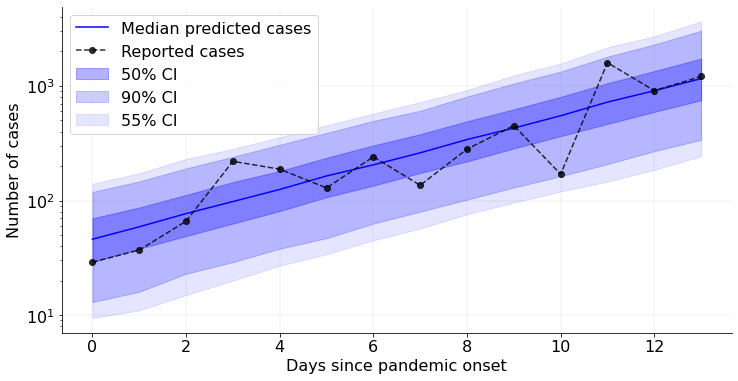

In [15]:
plot_median_predictions(5000, obs_germ_tensor, font_size=16, filename='Initial_dummy')

## Calibration

In [36]:
n_sbc = 10000
test_data_sbc = data_gen(n_sbc)

In [37]:
theta_samples = np.concatenate([model.sample(x, 250, to_numpy=True) 
                                for x in tf.split(test_data_sbc['x'], 20, axis=0)], axis=1)
theta_samples[theta_samples<0] = np.nan

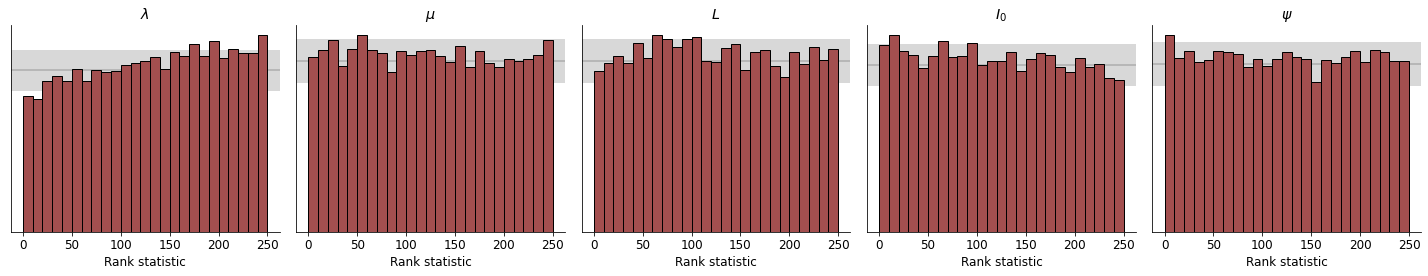

In [38]:
plot_sbc(theta_samples[:, :, :5], 
         test_data_sbc['theta'][:, :5], 
         param_names[:5], 
         bins=25,
         figsize=(20, 4), 
         filename='SBC_Initial_Dummy')

## Pairplots of posteriors

In [24]:
samples_g = model.sample(np.log1p(obs_germ_tensor), 10000, to_numpy=True)
samples_g = samples_g[np.sum(samples_g < 0, axis=1) == 0]

In [28]:
data = pd.DataFrame(samples_g[:, :5], columns=param_names[:5])

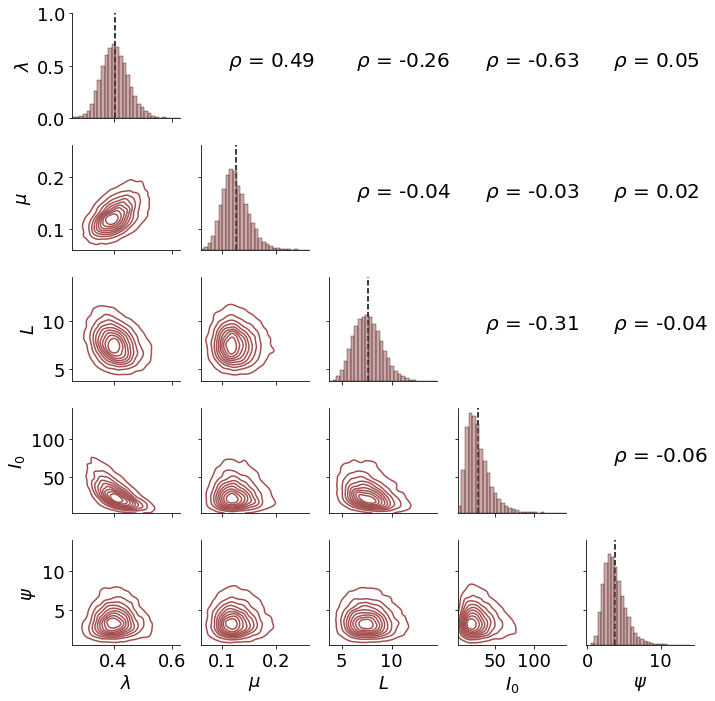

In [43]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(r"$\rho$ = {:.2f}".format(r),
                xy=(.25, .5), xycoords=ax.transAxes, fontsize=20)

    
plt.rcParams['font.size'] = 18
grid = sns.PairGrid(data, height = 2)
grid = grid.map_diag(sns.histplot, alpha=0.5, bins=30, color='#a34f4f')
grid = grid.map_lower(sns.kdeplot, n_levels=10, cut=0, color='#a34f4f', bw_method='silverman',)
grid = grid.map_upper(corrfunc)

for i, j in zip(*np.triu_indices_from(grid.axes, 1)):
    grid.axes[i, j].axis('off')
    
for i in range(len(param_names[:5])):
    grid.axes[i, i].axvline(data.iloc[:, i].mean(), color='black', linestyle='dashed')

In [44]:
grid.savefig("figures/Initial_Pairs_Dummy.png", dpi=300)